## Introduction to the SVM Technique:

(https://www.geeksforgeeks.org/machine-learning/support-vector-machine-algorithm/)

The Support Vector Machine algorithm serves as a powerful machine learning algorithm that is based on supervised learning and is primarily used for classification and regression tasks. This algorithm is very useful in binary classification tasks, such as distinguishing between spam or legitimate emails or identifying images of cats against dogs.

## How the Support Vector Machine algorithm works:

The main objective behind the Support Vector Machine algorithm is to find an optimal hyperplane in an N-dimensional space that distinctly classifies the data points. This is done by maximizing the distance from the hyperplane to the nearest data points (known as support vectors). This is achieved by maximizing the distance between the hyperplane and the nearest data points, which are called support vectors. In this way, the model would perform better when new and unseen data is introduced. To handle non-linear separable data, the SVM technique maps input vectors into higher-dimensional feature spaces using kernels such as the Radial Basis Function (RBF) kernel.

## Advantages of SVMs:

1. The Support Vector Machine algorithm works well when the number of features is greater than the number of samples.

2. The Support Vector Machine algorithm can make use of kernel functions like RBF and polynomial to effectively handle nonlinear relationships

3. The Support Vector Machine algorithm is effective for both binary classification and multiclass classification suitable for applications in text classification.

4. Since the algorithm focuses on support vectors, this technique is memory efficient when compared to technique like Random Forest

## Limitations:

1. The Support Vector Machine algorithm is slow for large datasets, affecting performance in SVM in data mining tasks.

2. Selecting the right kernel and adjusting parameters like C requires careful tuning, impacting Support Vector Machine algorithms

3. The algorithm struggles with noisy datasets and overlapping classes, limiting its impact in real-world scenarios

4. The algorithm requires proper feature scaling in order to perform well.

## Suitability to the task:

Support Vector Machines (SVM) are suitable for analysing traffic accident data which is gathered from various police press releases and local news articles. This is because the SVM algorithm can identify the severe and fatal accidents that are extremely rare within small and imbalanced datasets without being overwhelmed by the large number of minor accidents. By using class weighting and a non-linear kernel, the algorithm can identify any relationships between accident characteristics and injury severity and can also make accurate predictions on new and previously unseen accidents. Thus, the SVM algorithm is the best algorithm that can predict injury outcomes and support road safety analysis.

## Part 1: Importing Libraries

In [1]:
## Data Processing
import pandas as pd
import numpy as np
import ast
## Plotting
import seaborn as sns
import matplotlib.pyplot as plt
## SVM Model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, cross_validate
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from sklearn.metrics import ( accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, balanced_accuracy_score, roc_auc_score, precision_recall_curve)
from sklearn.preprocessing import label_binarize
from sklearn.base import clone

## Part 2: Loading the Dataset:

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('combined_accidents_clean.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   publish_date                232 non-null    object
 1   content                     232 non-null    object
 2   time_24h                    232 non-null    object
 3   corrected_date              232 non-null    object
 4   injury_severity             232 non-null    object
 5   affected_party              232 non-null    object
 6   primary_accident_type_code  232 non-null    object
 7   age                         232 non-null    object
 8   ages_after_driven_by        232 non-null    object
 9   driver_age_min              232 non-null    int64 
 10  location                    231 non-null    object
 11  street                      231 non-null    object
 12  locality                    216 non-null    object
 13  day_of_week_num             232 non-null    int64 

In [4]:
df.isnull().sum()
#location, street and locality have missing values, but it will not be used for predictions. Other columns have no missing values

publish_date                   0
content                        0
time_24h                       0
corrected_date                 0
injury_severity                0
affected_party                 0
primary_accident_type_code     0
age                            0
ages_after_driven_by           0
driver_age_min                 0
location                       1
street                         1
locality                      16
day_of_week_num                0
rush_hour                      0
rain_today                     0
rain_last_3h                   0
roadworks_nearby               0
street_had_speed_camera        1
vehicle_type_score             0
age_min_encoded                0
age_list                       0
time_period                    0
dtype: int64

<Axes: ylabel='count'>

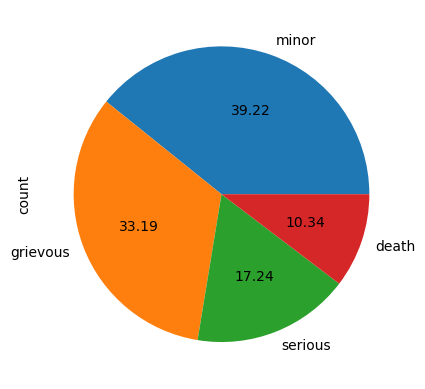

In [5]:
df['injury_severity'].value_counts().plot.pie(autopct='%.2f')

Before deciding which models to use, the dataset had to be balanced to improve our results. This dataset was balanced according to these assumptions:

1. Injuries that were classified as Grievous and Serious injuries were merged into a class called Grievous
2. According to the WHO, if death occurred within a month since the accident, then the accident is considered to be death. In fact, according to a study which was held in the US (https://pmc.ncbi.nlm.nih.gov/articles/PMC3603725/), 20% of grievously injured people die within a month from the accident. Thus, a decision was taken to take 20% of grievous injuries and reclassify them as death. The random reclassification of 20% grievous injuries to death is done only once, for reproducibility. The reclassed dataset is written into a new file "combined_accidents_balanced.csv" and then loaded for processing.

<Axes: ylabel='count'>

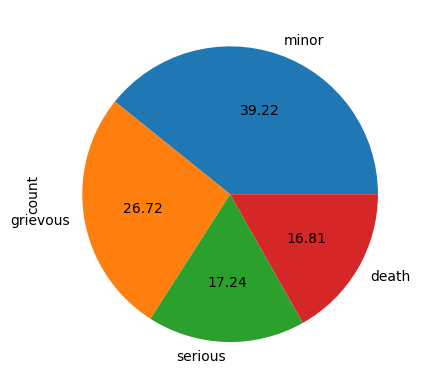

In [6]:
df = pd.read_csv('combined_accidents_balanced.csv')
df['injury_severity'].value_counts().plot.pie(autopct='%.2f')

## Part 3: Feature Encoding

After the dataset was balanced, the process of feature encoding was employed. In order for the SVM algorithm to function properly, proper encoding and preprocessing must be employed. These algorithms do not require one-hot encoding. In fact, the algorithms may perform worse because one-hot encoding adds more columns. As such, ordinal encoding was the feature encoding technique that was chosen.

injury_severity
1    102
0     91
2     39
Name: count, dtype: int64


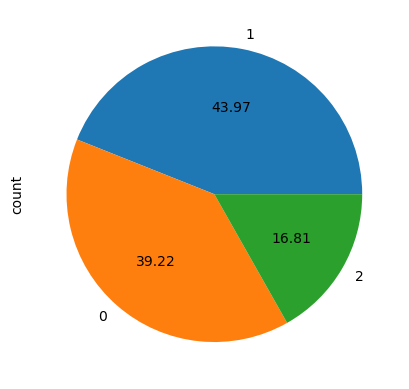

In [7]:
# ===============================
# Time processing
# ===============================
# Convert the 'time_24h' column from string format (HH:MM) to datetime
# and extract only the hour component (0–23).
# This converts time into a numerical feature usable by the SVM model.
df["time_24h"] = pd.to_datetime(
    df["time_24h"], format="%H:%M", errors="coerce"
).dt.hour
# Time in 24 hours is split into time-of-day categories.
# This reduces noise and captures meaningful temporal patterns
# (e.g. rush hours vs night-time accidents).
df["time_period"] = pd.cut(
    df["time_24h"],
    bins=[0, 6, 12, 17, 24],
    labels=["Night", "Morning", "Afternoon", "Evening"],
    right=False
)
#encoding the injury severity column
df_new = df[['injury_severity','affected_party','primary_accident_type_code','day_of_week_num','rain_today','vehicle_type_score','age_min_encoded','rush_hour','time_period']].copy()
ordinal_mapping_injure = {'minor':0,'serious':1,'grievous':1, 'death':2}
df_new['injury_severity'] = df_new['injury_severity'].map(ordinal_mapping_injure)

df_new['injury_severity'].value_counts().plot.pie(autopct='%.2f')
print(df_new['injury_severity'].value_counts())

In [8]:
print(df_new['injury_severity'].value_counts())

injury_severity
1    102
0     91
2     39
Name: count, dtype: int64


In [9]:
#encoding the affected party column 
ordinal_mapping_affected = {'pedestrian':0,'cyclist':1,'motorcyclist':2, 'driver':3}
df_new['affected_party'] = df_new['affected_party'].map(ordinal_mapping_affected)
df_new['affected_party']

0      0
1      2
2      0
3      3
4      3
      ..
227    0
228    2
229    3
230    2
231    3
Name: affected_party, Length: 232, dtype: int64

In [10]:
#encoding the accident type code column 
ordinal_mapping_accidentType = {'FXOBJ':0,'PED':1,'COLL':2, 'OTH':3}
df_new['primary_accident_type_code'] = df_new['primary_accident_type_code'].map(ordinal_mapping_accidentType)
df_new['primary_accident_type_code']

0      1
1      0
2      1
3      2
4      2
      ..
227    1
228    2
229    2
230    2
231    2
Name: primary_accident_type_code, Length: 232, dtype: int64

In [11]:
#encoding the accident type code column 
df_new['rain_today'] = df_new['rain_today'].astype(int)
df_new['rain_today']

0      0
1      0
2      0
3      0
4      0
      ..
227    1
228    0
229    0
230    0
231    0
Name: rain_today, Length: 232, dtype: int32

In [12]:
#encoding time period
ordinal_mapping_time = {'Night':0,'Morning':1,'Afternoon':2, 'Evening':3}
df_new['time_period'] = df_new['time_period'].map(ordinal_mapping_time)
df_new['time_period']

0      1
1      3
2      3
3      3
4      3
      ..
227    1
228    1
229    1
230    1
231    1
Name: time_period, Length: 232, dtype: category
Categories (4, int64): [0 < 1 < 2 < 3]

In [13]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   injury_severity             232 non-null    int64   
 1   affected_party              232 non-null    int64   
 2   primary_accident_type_code  232 non-null    int64   
 3   day_of_week_num             232 non-null    int64   
 4   rain_today                  232 non-null    int32   
 5   vehicle_type_score          232 non-null    int64   
 6   age_min_encoded             232 non-null    int64   
 7   rush_hour                   232 non-null    int64   
 8   time_period                 232 non-null    category
dtypes: category(1), int32(1), int64(7)
memory usage: 14.1 KB


## Data splitting into train, validation and test

The balanced dataset was then split into 3 subsets which are:

1. The training set - Will be used for model training and would use 60% of the entire dataset
2. The validation set - Will be used for hyperparameter tuning and would use 20% of the entire dataset
3. The test set - Will be used for the final evaluation of the model's performance and would use 20% of the entire dataset

However, since the dataset used for the traffic accident reports is small, by splitting it into three parts the modelling process may be negatively affected as there may be not enough data available to effectively train, validate, and test the algorithms.

In [14]:
#splitting data into train, validate and test sets 

def split_stratified_into_train_val_test(df_in, stratify_columnName='injury_severity',
                                         fractionTrain=0.7, fractionVal=0.15, fractionTest=0.15,
                                         randomState=42):
    ## The dataset would be split the Pandas datafram into three subsets (train, val, and test) and
    ## would follow the 60/20/20 ratio split. Each subset would have the same relative frequency of
    ## the values in the column. The data splitting process is performed by running train_test_split() twice
    
    if fractionTrain + fractionVal + fractionTest != 1.0:
        raise ValueError('fractions %f, %f, %f do not add up to 1.0' % \
                         (fractionTrain, fractionVal, fractionTest))

    if stratify_columnName not in df_in.columns:
        raise ValueError('%s is not a column in the dataframe' % (stratify_columnName))

    X = df_in # Contains all columns.
    y = df_in[[stratify_columnName]] # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          test_size=(1.0 - fractionTrain),
                                                          random_state=randomState)

    # Split the temp dataframe into val and test dataframes.
    relative_fractionTest = fractionTest / (fractionVal + fractionTest)
    df_val, df_test, y_val, y_test = train_test_split(df_temp,
                                                      y_temp,
                                                      stratify=y_temp,
                                                      test_size=relative_fractionTest,
                                                      random_state=randomState)

    assert len(df_in) == len(df_train) + len(df_val) + len(df_test)

    return df_train, df_val, df_test

train, val, test = split_stratified_into_train_val_test(df_new, stratify_columnName='injury_severity', fractionTrain=0.6, fractionVal=0.2, fractionTest=0.20)

# Show the number of observations for the train, validate and test dataframes
print('Number of observations in the training set:', len(train))
print('Number of observations in the validate set:',len(val))
print('Number of observations in the validate set:',len(test))

Number of observations in the training set: 139
Number of observations in the validate set: 46
Number of observations in the validate set: 47


In [15]:
x_parameters = ['primary_accident_type_code','affected_party','rain_today','vehicle_type_score','age_min_encoded']

y_train = train['injury_severity']
X_train = train[x_parameters]

y_val = val['injury_severity']
X_val = val[x_parameters]

y_test = test['injury_severity']
X_test = test[x_parameters]

numeric_features = [
    "vehicle_type_score",
    "age_min_encoded"
]

categorical_features = [
    "primary_accident_type_code",
    "affected_party",
    "rain_today"
]

# -----------------------
# Preprocessing pipelines
# -----------------------
# Numerical preprocessing pipeline:
# - Missing values are imputed using the median (robust to outliers)
# - Features are standardised to zero mean and unit variance
#   This step is essential for SVM, as it is sensitive to feature scale
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

## Part 4a. Baseline SVM Model & Cross-validation, without class balancing
To evaluate and test the Support Vector Machine algorithm, the following metrics were used:

1. The f1 score was selected as the main evaluation metric to evaluate the SVM model. This is because the target classes are imbalanced (there are three times fewer fatalities than other classes, even after reclassifying 20% of grievous injuries to fatalities). It combines Precision and Recall in the following formulas: 
    Precision = True Positives / (True Positives + False Positives). 
    F1 score = 2*(Precision * Recall)/Precision + Recall

2. Balanced accuracy was chosen as an additional evaluation metric for the SVM model since it's well suited to multiclass classification tasks that involve imbalanced datasets. It is calculated as the average of recall across all classes, where recall is defined as the ratio of true positives to the sum of true positives and false negatives (Recall = True Positives / (True Positives + False Negatives))

3. Accuracy was also used as an additional evaluation metric: Accuracy score = Number of Correct Predictions / Number of Total Predictions.

In [16]:
#Initialising the model with default parameters
svm_baseline = Pipeline([
    ("preprocessor", preprocessor),
    ("svc", SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        random_state=42
    ))
])

In [17]:
# Cross-validation on TRAIN set
f1_scores_train = cross_val_score(
    svm_baseline, X_train, y_train,
    cv=5, scoring="f1_weighted"
)
mean_f1_scores_train = np.mean(f1_scores_train)

bal_accuracy_scores_train = cross_val_score(
    svm_baseline, X_train, y_train,
    cv=5, scoring="balanced_accuracy"
)
mean_bal_accuracy_train = np.mean(bal_accuracy_scores_train)

accuracy_scores_train = cross_val_score(
    svm_baseline, X_train, y_train,
    cv=5, scoring="accuracy"
)
mean_accuracy_train = np.mean(accuracy_scores_train)
# Train the model on the full training data
svm_baseline.fit(X_train, y_train)
# Make predictions on the validation set
y_pred_validation = svm_baseline.predict(X_val)

# Calculate f1_weighted and accuracy on the validation set
f1_scores_validation = f1_score(y_val, y_pred_validation, average="weighted")
bal_accuracy_validation = balanced_accuracy_score(y_val, y_pred_validation)
accuracy_validation = accuracy_score(y_val, y_pred_validation)
# Display results
df_labels = pd.Series([
    "Imbalanced Train Set CV Mean F1-weighted",
    "Imbalanced Train Set CV Mean Balanced Accuracy",
    "Imbalanced Train Set CV Mean Accuracy",
    "Imbalanced Train Set Validation F1-weighted",
    "Imbalanced Train Set Validation Balanced Accuracy",
    "Imbalanced Train Set Validation Accuracy"
], name="Performance_Metrics")

df_values = pd.Series([
    mean_f1_scores_train,
    mean_bal_accuracy_train,
    mean_accuracy_train,
    f1_scores_validation,
    bal_accuracy_validation,
    accuracy_validation
], name="Performance_Metrics_Values")

df_svm_baseline = pd.concat([df_labels, df_values], axis=1)
df_svm_baseline
#the CV metrics show that the model safficiently generalises over the training set.

,Performance_Metrics,Performance_Metrics_Values
0,Imbalanced Train Set CV Mean F1-weighted,0.719405
1,Imbalanced Train Set CV Mean Balanced Accuracy,0.626970
2,Imbalanced Train Set CV Mean Accuracy,0.776720
3,Imbalanced Train Set Validation F1-weighted,0.619375
4,Imbalanced Train Set Validation Balanced Accuracy,0.546296
5,Imbalanced Train Set Validation Accuracy,0.673913


## Part 4b. Baseline SVM Model and Cross-validation, with Random Oversampling

In [18]:
#the dataset is imbalanced, so let us oversample minority classes to balance the data out
# Method 1. Oversampling of minority classes
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
randomOverSampler = RandomOverSampler(random_state=42, sampling_strategy='not majority')

X_res_randomOverSampler, y_res_randomOverSampler = randomOverSampler.fit_resample(X_train,y_train)
y_res_randomOverSampler.value_counts()

injury_severity
1    61
2    61
0    61
Name: count, dtype: int64

In [20]:
# Cross-validation model with oversampled minority class in the training data
f1_scores_res_randomOverSampler = cross_val_score(svm_baseline, X_res_randomOverSampler, y_res_randomOverSampler, cv=5, scoring='f1_weighted') #cross-validation over 5 K-fold splits in training data
mean_f1_scores_res_randomOverSampler = np.mean(f1_scores_res_randomOverSampler)

bal_accuracy_scores_res_randomOverSampler = cross_val_score(svm_baseline, X_res_randomOverSampler, y_res_randomOverSampler, cv=5, scoring='balanced_accuracy') #cross-validation over 5 stratified K-fold train-test splits
mean_bal_accuracy_res_randomOverSampler = np.mean(bal_accuracy_scores_res_randomOverSampler)

accuracy_scores_res_randomOverSampler = cross_val_score(svm_baseline, X_res_randomOverSampler, y_res_randomOverSampler, cv=5, scoring='accuracy') #cross-validation over 5 stratified K-fold train-test splits
mean_accuracy_res_randomOverSampler = np.mean(accuracy_scores_res_randomOverSampler)

# Train the model on the full training data
svm_baseline.fit( X_res_randomOverSampler, y_res_randomOverSampler)

# Make predictions on the validation set
y_pred_res_randomOverSampler = svm_baseline.predict(X_val)

# Calculate f1_weighted, balanced accuracy and accuracy on the validation set
f1_scores_val_res_randomOverSampler = f1_score(y_val, y_pred_res_randomOverSampler, average='weighted')
bal_accuracy_val_res_randomOverSampler = balanced_accuracy_score(y_val, y_pred_res_randomOverSampler)
accuracy_val_res_randomOverSampler = accuracy_score(y_val, y_pred_res_randomOverSampler)

# Display results

df_labels = pd.Series(['Oversampled Train Set CV Mean_f1_scores','OversampledTrain Set CV Mean Balanced Accuracy', 
                       'Oversampled Train Set CV Mean Accuracy','Oversampled Train Set / F1 weighted score Val Set',
                       'Oversampled Tain Set/ Balanced Accuracy Val Set','Oversampled Tain Set/ Accuracy Val Set'], name='Performance_Metrics:')
dfSVM2_values = pd.Series([mean_f1_scores_res_randomOverSampler, mean_bal_accuracy_res_randomOverSampler,mean_accuracy_res_randomOverSampler,f1_scores_val_res_randomOverSampler,bal_accuracy_val_res_randomOverSampler,accuracy_val_res_randomOverSampler],name = 'Performance_Metrics_Values')
dfSVM2 = pd.concat([df_labels, dfSVM2_values], axis =1)
dfSVM2

,Performance_Metrics:,Performance_Metrics_Values
0,Oversampled Train Set CV Mean_f1_scores,0.701000
1,OversampledTrain Set CV Mean Balanced Accuracy,0.704274
2,Oversampled Train Set CV Mean Accuracy,0.705105
3,Oversampled Train Set / F1 weighted score Val Set,0.754915
4,Oversampled Tain Set/ Balanced Accuracy Val Set,0.812963
5,Oversampled Tain Set/ Accuracy Val Set,0.760870


## 4d. Baseline Crossvalidation (Imbalanced and Oversampled), comparison

In [21]:
dfSVM3 = pd.concat([df_svm_baseline.Performance_Metrics_Values, 
                dfSVM2.Performance_Metrics_Values,
                            ], axis =1)

dfSVM3.columns = ['No class balancing', 'Random Oversampling']
dfSVM3 = dfSVM3.T
dfSVM3.columns = ['CV Mean_f1_scores', 'CV Mean_Balanced_Accuracy','CV Mean Accuracy', 'f1_score Val Set', 'Balanced Accuracy Val Set','Accuracy Val Set']
dfSVM3

,CV Mean_f1_scores,CV Mean_Balanced_Accuracy,CV Mean Accuracy,f1_score Val Set,Balanced Accuracy Val Set,Accuracy Val Set
No class balancing,0.719405,0.626970,0.776720,0.619375,0.546296,0.673913
Random Oversampling,0.701000,0.704274,0.705105,0.754915,0.812963,0.760870


The metrics show that the training set with random oversampling is better at classifying target classes, so I will use random oversampling for hyperparameter tuning.

## 5a. Model training and hyperparameter tuning using the validation set

In [23]:
# Define the parameter grid for GridSearchCV
param_grid = {
    "svc__C": [0.1, 1, 10, 100],
    "svc__gamma": [0.01, 0.1, 1],
    "svc__kernel": ["rbf", "poly", "sigmoid"]
}
svm_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("svc", SVC(class_weight="balanced", probability=True, random_state=42))
])
score = ["accuracy", "balanced_accuracy", "f1_weighted"]
# Set up GridSearchCV
grid_search_svm = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring=score,
    refit="f1_weighted",  # pick the best model according to F1-weighted
    n_jobs=-1,
    verbose=1
)
# Fit GridSearchCV to the oversampled training data
grid_search_svm.fit(X_res_randomOverSampler, y_res_randomOverSampler)
# Get the best model from GridSearchCV and make predictions
best_svm_model = grid_search_svm.best_estimator_
y_pred_validation = best_svm_model.predict(X_val)

# Calculate f1 score and accuracy for the best model
f1_scores_validation = f1_score(y_val, y_pred_validation, average='weighted')
bal_accuracy_validation = balanced_accuracy_score(y_val, y_pred_validation)
accuracy_validation = accuracy_score(y_val, y_pred_validation)

#CV mean weighted F1 score
mean_f1_scores_total = np.mean(grid_search_svm.cv_results_['mean_test_f1_weighted'])
std_f1_scores_total = np.std(grid_search_svm.cv_results_['mean_test_f1_weighted'])

#CV mean balanced accuracy score
mean_bal_acc_scores_total = np.mean(grid_search_svm.cv_results_['mean_test_balanced_accuracy'])
std_bal_acc_scores_total = np.std(grid_search_svm.cv_results_['mean_test_balanced_accuracy'])

#CV mean balanced accuracy score
mean_acc_scores_total = np.mean(grid_search_svm.cv_results_['mean_test_accuracy'])
std_acc_scores_total = np.std(grid_search_svm.cv_results_['mean_test_accuracy'])

#Mean fit time
mean_fit_time_total = np.mean(grid_search_svm.cv_results_['mean_fit_time'])
std_fit_time_total = np.std(grid_search_svm.cv_results_['mean_fit_time'])

# Display results
print(f"Best Hyperparameters from Grid Search: {grid_search_svm.best_params_}")
print(f"Grid Search Mean F1 Weighted Score: {mean_f1_scores_total:.2f} ± {std_f1_scores_total:.2f}")
print(f"Grid Search Mean Balanced Accuracy Score: {mean_bal_acc_scores_total:.2f} ± {std_bal_acc_scores_total:.2f}")
print(f"Grid Search Mean Accuracy Score: {mean_acc_scores_total:.2f} ± {std_acc_scores_total:.2f}")
print(f"Best Model F1 Weighted Score (Val Set): {f1_scores_validation:.2f}")
print(f"Best Model Balanced Accuracy (Val Set): {bal_accuracy_validation:.2f}")
print(f"Best Model Accuracy (Val Set): {accuracy_validation:.2f}")
print(f"Grid Search Mean Fit Time, s: {mean_fit_time_total:.2f} ± {std_fit_time_total:.2f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Hyperparameters from Grid Search: {'svc__C': 1, 'svc__gamma': 1, 'svc__kernel': 'rbf'}
Grid Search Mean F1 Weighted Score: 0.54 ± 0.15
Grid Search Mean Balanced Accuracy Score: 0.57 ± 0.13
Grid Search Mean Accuracy Score: 0.57 ± 0.13
Best Model F1 Weighted Score (Val Set): 0.71
Best Model Balanced Accuracy (Val Set): 0.71
Best Model Accuracy (Val Set): 0.72
Grid Search Mean Fit Time, s: 0.03 ± 0.00


## 5b. Hyperparameter visualisation

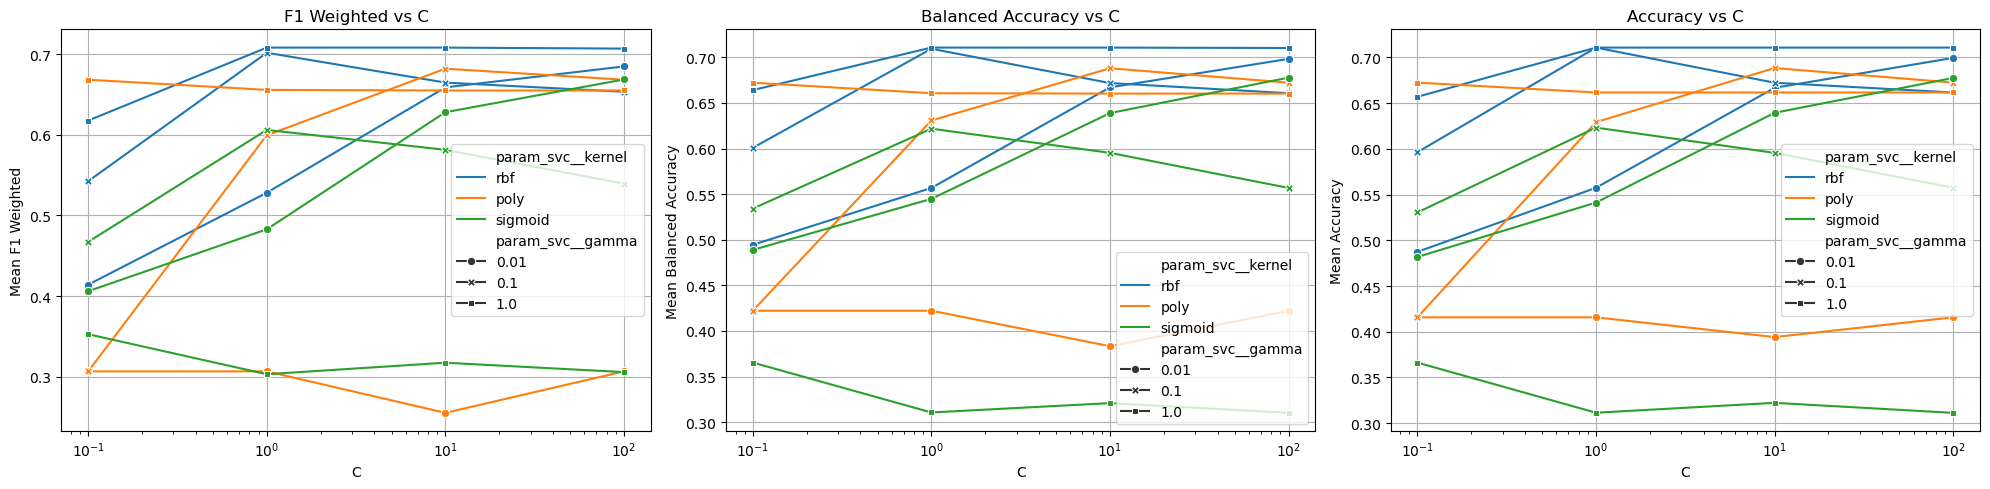

In [24]:
# Convert GridSearchCV results to DataFrame
results = pd.DataFrame(grid_search_svm.cv_results_)

# -----------------------------
# Lineplots: F1, Balanced Accuracy, Accuracy vs C
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(20, 5))  # 1 row, 3 columns

# F1 Weighted vs C
sns.lineplot(
    data=results,
    x='param_svc__C',
    y='mean_test_f1_weighted',
    hue='param_svc__kernel',
    style='param_svc__gamma',
    markers=True,
    dashes=False,
    ax=axes[0]
)
axes[0].set_xscale('log')
axes[0].set_xlabel('C')
axes[0].set_ylabel('Mean F1 Weighted')
axes[0].set_title('F1 Weighted vs C')
axes[0].grid(True)

# Balanced Accuracy vs C
sns.lineplot(
    data=results,
    x='param_svc__C',
    y='mean_test_balanced_accuracy',
    hue='param_svc__kernel',
    style='param_svc__gamma',
    markers=True,
    dashes=False,
    ax=axes[1]
)
axes[1].set_xscale('log')
axes[1].set_xlabel('C')
axes[1].set_ylabel('Mean Balanced Accuracy')
axes[1].set_title('Balanced Accuracy vs C')
axes[1].grid(True)

# Accuracy vs C
sns.lineplot(
    data=results,
    x='param_svc__C',
    y='mean_test_accuracy',
    hue='param_svc__kernel',
    style='param_svc__gamma',
    markers=True,
    dashes=False,
    ax=axes[2]
)
axes[2].set_xscale('log')
axes[2].set_xlabel('C')
axes[2].set_ylabel('Mean Accuracy')
axes[2].set_title('Accuracy vs C')
axes[2].grid(True)

# Adjust layout for the lineplots
plt.tight_layout()
plt.show()

## 5c. Model Tuning: Applying the best hyperparameters to the test data set

In [27]:
dict_weights = {0:1, 1: 1, 2:2}

#best hyperparameters
best_svm_tuned = Pipeline([
    ("preprocessor", preprocessor),
    ("svc", SVC(
        C=10,               # best C from grid search
        gamma=0.1,          # best gamma from grid search
        kernel='rbf',       # best kernel from grid search
        class_weight=dict_weights,  # apply weights to classes
        probability=True,   # to allow predict_proba
        random_state=42
    ))
])
# Train the model on the training data 
best_svm_tuned.fit(X_train, y_train)

# Make predictions on the test set
y_pred_svm_tuned = best_svm_tuned.predict(X_test)
y_tuned_svm_score = best_svm_tuned.predict_proba(X_test)  # probabilities for ROC/AUC

# Calculate metrics on the test set
f1_scores_test = f1_score(y_test, y_pred_svm_tuned, average='weighted')
bal_accuracy_test = balanced_accuracy_score(y_test, y_pred_svm_tuned)
accuracy_test = accuracy_score(y_test, y_pred_svm_tuned)

print(f"Tuned SVM Test Set F1 Weighted: {f1_scores_test:.2f}")
print(f"Tuned SVM Test Set Balanced Accuracy: {bal_accuracy_test:.2f}")
print(f"Tuned SVM Test Set Accuracy: {accuracy_test:.2f}")

Tuned SVM Test Set F1 Weighted: 0.81
Tuned SVM Test Set Balanced Accuracy: 0.75
Tuned SVM Test Set Accuracy: 0.81


## 6. Assessing the Performance of the Tuned Model

## 6a. Classification Report and Confusion Matrix

In [29]:
#printing classification report
labels = ["minor", "severe", "death"]
print("\nClassification Report (Test Set):\n")
print(classification_report(y_test, y_pred_svm_tuned, target_names=labels))
#precision, recall and f1 score are the lowest for those accidents whose injury_severity = death


Classification Report (Test Set):

              precision    recall  f1-score   support

       minor       1.00      0.83      0.91        18
      severe       0.76      0.90      0.83        21
       death       0.57      0.50      0.53         8

    accuracy                           0.81        47
   macro avg       0.78      0.75      0.76        47
weighted avg       0.82      0.81      0.81        47



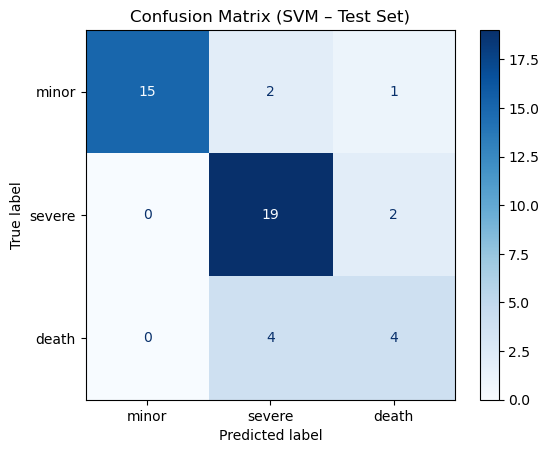

In [31]:
cm = confusion_matrix(y_test, y_pred_svm_tuned)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=labels
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (SVM – Test Set)")
plt.show()

## 6b. Precision-Recall Curve and ROC Curve

The Precision-Recall Curve is better suited to evaluate a model performance of imbalanced datasets

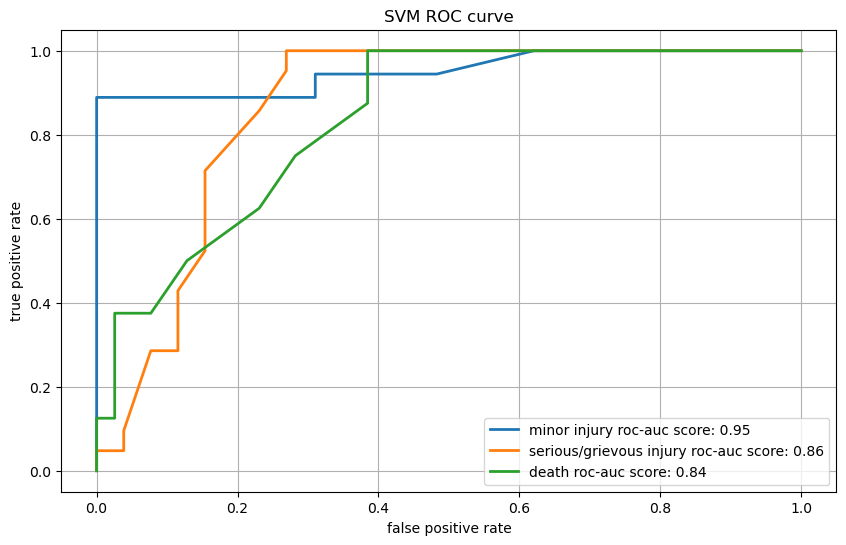

In [34]:
false_positives = dict() #false positives
true_positives = dict() #true positives
SVM_roc_auc = dict() #roc_auc_score
n_classes = len(set(y_test))
y_test_binary = label_binarize(y_test, classes=[*range(n_classes)])
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    false_positives[i], true_positives[i], _ = roc_curve(y_test_binary[:, i],
                                  y_tuned_svm_score[:, i])
    SVM_roc_auc[i] = roc_auc_score(y_test_binary[:, i],
                                  y_tuned_svm_score[:, i])

    
    plt.plot(false_positives[i], true_positives[i], lw=2, label='class {}'.format(i))

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")

label1 = (f"minor injury roc-auc score: {SVM_roc_auc[0]:.2f}")
label2 = (f"serious/grievous injury roc-auc score: {SVM_roc_auc[1]:.2f}")
label3 = (f"death roc-auc score: {SVM_roc_auc[2]:.2f}")
plt.legend(labels = [label1, label2, label3],loc="best")
plt.title("SVM ROC curve")
plt.grid(True)
plt.show()

In the case of a well-performing model, the true positive rate rises sharply towards 1 almost immediately and then progresses horizontally. This shows that the model is most confident at classifying minor injuries (which is expected since the dataset includes multiple instances of minor injuries for drivers in collisions). The model is least confident at predicting fatalities

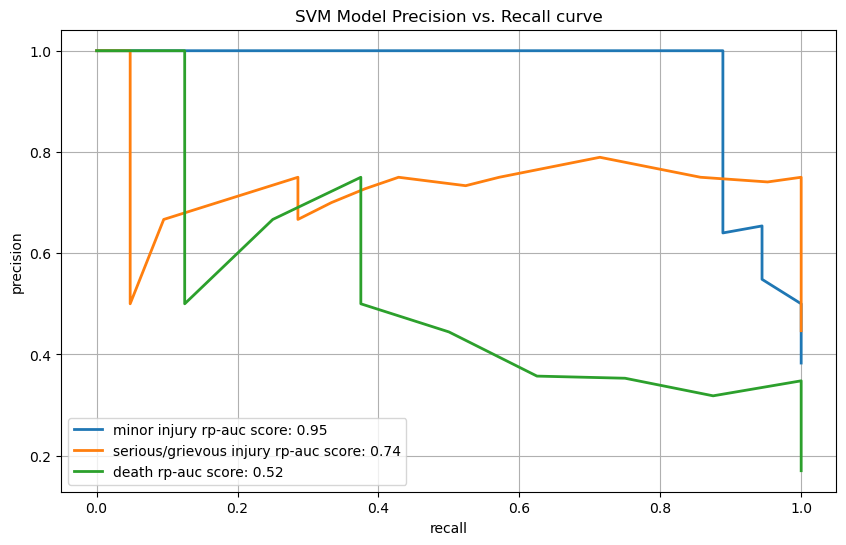

In [36]:
precision = dict()
recall = dict()
rp_auc_score = dict() #pr_auc score

# Generate precision-recall curve
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    precision[i], recall[i],_ = precision_recall_curve(y_test_binary[:, i],
                                                        y_tuned_svm_score[:,i])
    rp_auc_score[i] = auc(recall[i],precision[i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

    
plt.xlabel("recall")
plt.ylabel("precision")

label1 = (f"minor injury rp-auc score: {rp_auc_score[0]:.2f}")
label2 = (f"serious/grievous injury rp-auc score: {rp_auc_score[1]:.2f}")
label3 = (f"death rp-auc score: {rp_auc_score[2]:.2f}")
plt.legend(labels = [label1, label2, label3],loc="best")
plt.title("SVM Model Precision vs. Recall curve")
plt.grid(True)
plt.show()

In this SVC model, the PR-AUC score for fatal injuries is substantially lower than the other PR-AUC scores, indicating that although the model may appear to separate classes reasonably well, it performs poorly when identifying positive values for fatal cases without producing many negative values. This highlights the model’s difficulty in identifying rare outcomes and confirms that the PR-AUC score is more appropriate for datasets with significant class imbalance

## 7. Feature Importance Metrics

The Gini Impurity metric is a measure that is used to measure the mixed nature of a dataset. A Gini impurity of 0 indicates a perfectly pure node (all samples belong to the same class), while a higher value indicates a more random or mixed distribution of classes.

A high Gini Importance value means that the feature was commonly used to effectively split the data into cleaner, more homogeneous groups whilst a low Gini Importance value means that the feature had less impact on the decision-making process within the model.

In [39]:
svm_linear = SVC(kernel='linear', class_weight='balanced')
svm_linear.fit(X_train, y_train)

# Absolute magnitude of coefficients → feature importance
importances = np.abs(svm_linear.coef_).mean(axis=0)
feature_svm_imp_df = pd.DataFrame({'Feature': x_parameters, 'Importance': importances})
feature_svm_imp_df = feature_svm_imp_df.sort_values('Importance', ascending=False)
feature_svm_imp_df

,Feature,Importance
1,affected_party,1.362738
2,rain_today,0.609299
0,primary_accident_type_code,0.411760
3,vehicle_type_score,0.278292
4,age_min_encoded,0.232016


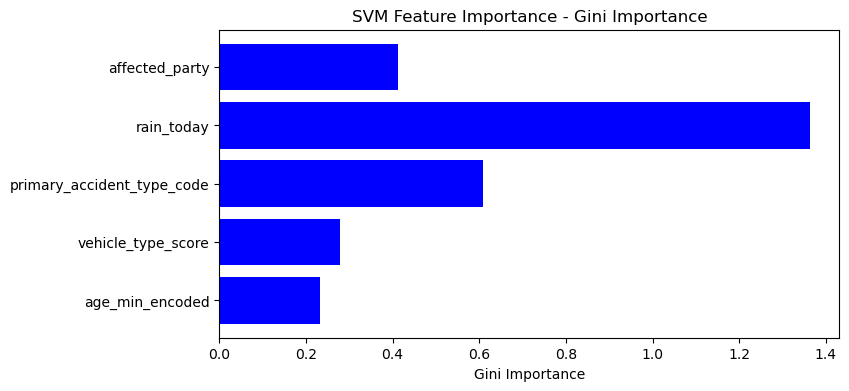

In [40]:
plt.figure(figsize=(8, 4))
plt.barh(feature_svm_imp_df["Feature"], importances, color='blue')
plt.xlabel('Gini Importance')
plt.title('SVM Feature Importance - Gini Importance')
plt.gca().invert_yaxis()
plt.show()

The Permutation Importance feature importance metric is computed once a model has been trained on the training set. It inquires: If the data points of a single attribute are randomly shuffled (in the test set), leaving all remaining data as is, what would be the ramifications on accuracy, using this new data? Ideally, random reordering of a column ought to result in reduced accuracy, since the new data has little or no correlation with real-world statistics. Model accuracy suffers most when an important feature, that the model was quite dependent on, is shuffled.

This parameter provides an insight into what features matter the most at the classification task.

In [42]:
targets = np.array(['No injury/Minor','Serious/Grievous','Death'])
features = np.array(x_parameters)
result = permutation_importance(
    best_svm_tuned, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)
perm_svm_imp_df = pd.DataFrame({'Feature': features, 'Permutation Importance': result.importances_mean}).sort_values(
    'Permutation Importance', ascending=False)
perm_svm_imp_df

,Feature,Permutation Importance
1,affected_party,0.318440
0,primary_accident_type_code,0.099291
3,vehicle_type_score,0.059574
4,age_min_encoded,-0.003546
2,rain_today,-0.012057


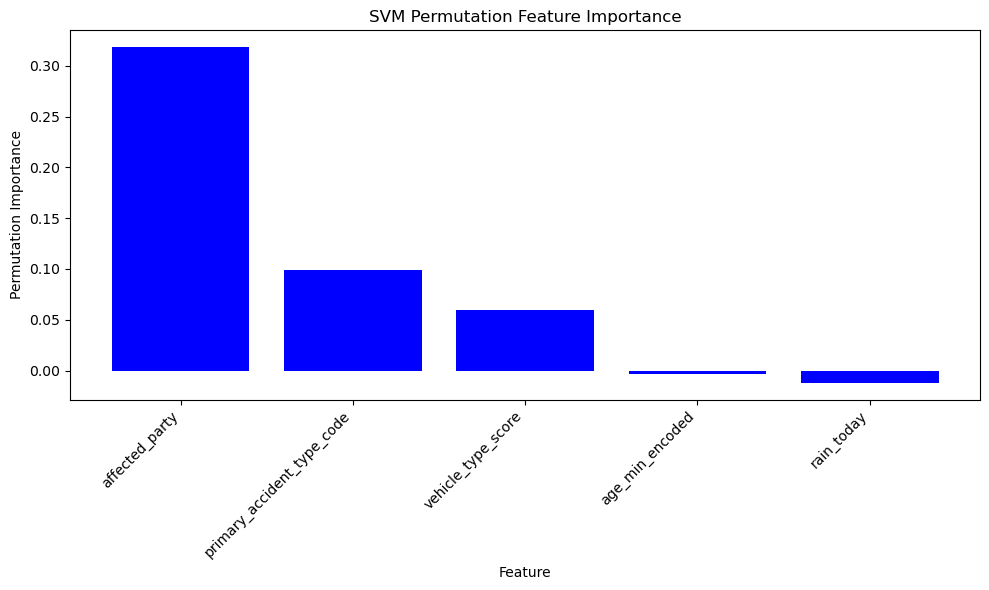

In [44]:
plt.figure(figsize=(10, 6))
plt.bar(perm_svm_imp_df['Feature'], perm_svm_imp_df['Permutation Importance'],color='blue')
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.title('SVM Permutation Feature Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

After analysing the permutation importance of the features of the SVM model, it was discovered that the 'affected_party' feature is the most influential feature as permuting this variable leads to the largest decrease in the predictive performance of the model. This suggests that information about which road user group is involved in the accident (e.g., driver, pedestrian, cyclist) plays a dominant role in determining injury severity. This discovery is important as different road users are exposed to varying levels of physical protection and vulnerability, which directly affects injury outcomes. 

The next most important feature is the 'primary_accident_type_code' feature as without knowing the type of the accident, the injury severity cannot clearly be determined. Some types of accidents are more dangerous than others and are more likely to result in serious or fatal injuries. The model uses this information to better distinguish between different levels of injury severity.

The vehicle_type_score feature also provides a meaningful contribution. This highlights that the characteristics of the vehicle involved in the accident are still relevant, albeit secondary to the type of road user involved. While vehicle-related factors influence injury severity, their impact is monitored by the person involved in the accident.

In contrast to these three features, age_min_encoded and rain_today have little to no impact on the model’s predictive performance as they exhibit little to no permutation importance. 

In [45]:
## Saving Results obtained from the SVM Model into the results folder for comparision
df_SVM_results_labels = pd.Series(['F1Score','balanced_accuracy','accuracy','mean fit time'], name='Performance_Metrics:')
df_SVM_results_values = pd.Series([f1_scores_test, bal_accuracy_test, accuracy_test, mean_fit_time_total],name = 'Support_Vector_Machine_Values')
df_SVM_results = pd.concat([df_SVM_results_labels, df_SVM_results_values], axis =1)
df_SVM_results

,Performance_Metrics:,Support_Vector_Machine_Values
0,F1Score,0.808045
1,balanced_accuracy,0.746032
2,accuracy,0.808511
3,mean fit time,0.031206


In [47]:
## SVM Metrics Values
metrics_SVM_file = "results/SVM_performance_metrics.csv"
df_SVM_results.to_csv(metrics_SVM_file, index=False)

## Saving SVM Y test values
SVM_Y_test_file = "results/SVM_Ytest.csv"
y_test.to_csv(SVM_Y_test_file, index=False)

## Saving SVM Y predicted values
SVM_Y_pred_file = "results/SVM_Ypred.csv"
df_svm_y_pred = pd.DataFrame(y_pred_svm_tuned)
df_svm_y_pred.to_csv(SVM_Y_pred_file, index=False)

## Saving SVM Y prediction probabilities for the curve analysis
SVM_Y_score_file = "results/SVM_Y_pred_score.csv"
df_svm_y_pred_score = pd.DataFrame(y_tuned_svm_score)
df_svm_y_pred_score.to_csv(SVM_Y_score_file, index=False)

## Saving SVM Gini Importance
SVM_gini_file = "results/SVM_Gini_Importance.csv"
feature_svm_imp_df.to_csv(SVM_gini_file, index=False)

## Saving SVM Gini Importance
SVM_perm_file = "results/SVM_Perm_Importance.csv"
perm_svm_imp_df.to_csv(SVM_perm_file, index=False)

## Insights about the accidents:

The feature importance metrics used in this algorithm give important information on how the SVM model makes its classification decisions. Although the Gini Importance was calculated for the SVM model, this metric was not well suited for this model since SVMs do not make use of decision tree splits. As a result, the Gini-based feature importance values do not accurately reflect the decision-making process of the SVM model. The feature importance ranking that is produced by this method appeared inconsistent with both domain knowledge and permutation importance results—for example, the high importance assigned to the rain_today feature. Thus, permutation importance is considered a more appropriate and reliable method for interpreting feature influence in the SVM model.

The permutation importance results show that the affected party (e.g. pedestrian, cyclist, motorcyclist, driver or passenger) is the most influential feature in predicting injury severity. This indicates that the type of road user involved in an accident plays a central role in determining the outcome of the accident.

The SVM model deduced that car drivers and car passengers usually get minor injuries when they are in accidents with cars that are about the same size. However, this is strongly influenced by how the data was gathered as nearly all collisions involving cars were recorded as minor injury cases. This introduced a bias towards the lower injury severity for this group. Thus, the SVM model learns this relationship from the given dataset and not from any knowledge related to vehicle safety. It is important to note that the model does not record features that are related to vehicle safety, such as seat belts, airbags, or vehicle structural design. Thus, the observed relationship does not reflect the protective effect of these factors, but rather the primary distribution and labelling of injury outcomes in the dataset. Subsequently, the model's predictions for car drivers primarily capture dataset-driven correlations rather than causal relationships.

In contrast, accidents involving vulnerable road users—including pedestrians, cyclists, and motorcyclists can lead to serious or fatal injuries. This shows that these road users have a lack of physical protection and have a larger exposure to impact forces, thus increasing the severity of the accident lower collision speeds

The primary accident type is the second most important feature. This shows that the manner in which the accident occurred has a crucial role in influencing severity. When a vehicle hits a fixed object, the force of impact leaves no chance for survival. There is no opportunity to reduce the damage, and that is exactly why there is a huge spike in the rate of severe injuries for these types of accidents.

The vehicle_type_score is another critical feature especially for predicting fatalities. From this feature, it can be deduced that fatal injuries are more likely to occur when vulnerable road users are involved in collisions with larger or heavier vehicles, as these collisions involve higher impact forces. When vulnerable road users are involved in accidents that do not include large vehicles—such as motorcyclists colliding with fixed objects or pedestrians struck by cars—the model more frequently predicts serious or grievous injuries rather than death

Other contextual features, such as time of day, day of week, and location-related variables, contribute less to the classification outcome. These factors may influence whether an accident has occurred, but they are not the main factors when determining injury severity.

Overall, the SVM model shows that the affected user involved in the accident and the manner in which the accident occurred are important features that influence injury severity, with vehicle characteristics providing additional context, while temporal and environmental factors have a comparatively limited impact.

## Limitations, Suggested Improvements and Ethical Considerations:

## Limitations:

Data bias and class imbalance are the two biggest hurdles for the SVM model. The dataset is derived from media reports and police sources, which give too much importance towards serious injuries and fatalities leading to less minor injuries being reported. This results in a dataset that does not accurately reflect the true distribution of accident outcomes. 

To compensate for missing information in collision reports, additional instances of minor injuries —primarily involving car drivers — were added. While this approach increased class balance, it introduced a structural bias: most minor injury examples involve drivers in vehicle-to-vehicle collisions, limiting the model’s exposure to other minor injury scenarios such as pedestrians or cyclists involved in low-severity incidents.

Fatal injuries are very rare, and even larger datasets would still suffer from class imbalance. The model's performance on fatalities —especially in precision-recall— is weaker. This stems directly from this imbalance in the dataset. Furthermore, the current version ignores road categories and localized accident history. On high-speed routes, these specific variables are absolute deciders for how bad an injury gets. Without them in the mix, the model just isn't hitting its full predictive ceiling.

## Suggested Improvements:

The SVM model would be improved by addressing these limitations:

1. Official traffic accident databases would be applied to reduce a bias in reporting.

2. Features such as road type, speed limits, and traffic density would be included in the SVM model.

3. Oversampling isn't enough. Cost-sensitive learning would be a more robust way to handle the imbalance

4. The model could also leverage historical and spatial data to pinpoint localized risk "hotspots."

## Ethical Considerations:

Driver Sex was excluded from the SVM model despite its known statistical association with accident outcomes. By excluding sex, any potential discriminatory biases would be removed from the predictive system. By prioritizing ethically neutral and context-based features, the model would remain focused on situational risk factors rather than personal attributes.